#**PRÉLIMINAIRES**

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import random_correlation 
from sklearn.linear_model import LinearRegression 
from sklearn.neural_network import MLPRegressor 
from mpl_toolkits.mplot3d import Axes3D
%pip install ipython-autotime
%load_ext autotime

Note: you may need to restart the kernel to use updated packages.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.22 s (started: 2025-03-31 17:14:15 -04:00)


##**Paramêtres d'instance**

In [3]:
"""
Définition des termes nécessaires dans notre travail. Pour la compilation, les valeurs changeront en fonction de l'instance choisie 
"""

# Taux d'intérêt r mensuellement composé par instance

r_grande = 2.5*10**(-3)  
r_moyenne = 2.5*10**(-2.45) 
r_petite = 2.5*10**(-2.5)


# Nombre de mois T par instance
T_grande = 60 
T_moyenne = 15
T_petite = 8


# Nombre d'états par instance 
n_etats_grande = 20
n_etats_moyenne = 10
n_etats_petite = 3


# Création d'un dictionnaire imbriqué pour stocker les valeurs en fonction de l'instance choisie
valeurs = {
    "grande": {"r": r_grande, "T": T_grande, "n_etats": n_etats_grande},
    "moyenne": {"r": r_moyenne, "T": T_moyenne, "n_etats": n_etats_moyenne},
    "petite": {"r": r_petite, "T": T_petite, "n_etats": n_etats_petite}
}
# Choix de l'instance
#instance = "petite"
instance = "moyenne"
#instance = "grande"


# Accès aux valeurs stockées en fonction de l'instance choisie
if instance in valeurs:
    r = valeurs[instance]["r"]
    T = valeurs[instance]["T"]
    n_etats = valeurs[instance]["n_etats"]
else:
    print("Instance non valide")

# Nombre d'actifs risqués d
d = 3

# Seuil de tolérance R_0
R_0 = 0.04

# Création de mon vecteur initial de prix S_0 exprimé en milliers de dollars
S_0 = np.array([6, 7.5, 5.5, 6])

#Coefficient d'aversion au risque gamma
gamma = 1.2

time: 1.36 ms (started: 2025-03-31 17:14:16 -04:00)


##**Simulation du processus de prix**

###**Génération d'une matrice de Covariance**

In [4]:
seed = 229
np.random.seed(seed) #On fixe la clé de génération des nombres aléatoires
mu = np.random.uniform(0.0011, 0.0015, d)  # Génère un vecteur de taux de rendement moyens aléatoires entre 0.0011 et 0.0015 pour chaque actif du portefeuille
sigma = np.random.uniform(0.02, 0.05, d)  # Génère un vecteur d'écart-types aléatoires entre 0.02 et 0.05 pour chaque actif du portefeuille

# Génération d'une matrice de corrélation pour un mouvement brownien géométrique avec corrélation
if d == 1:
    corr = np.array([1])  # Si la dimension est égale à 1, la corrélation est fixée à 1 (pas de corrélation)
else:
    eig = np.random.uniform(0.01, 1, d)  # Génère un vecteur d'auto-valeurs aléatoires entre 0.1 et 1 pour la matrice de corrélation
    eig = eig / np.sum(eig) * d  # Assure que la somme des auto-valeurs est égale à la dimensionnalité
    corr = random_correlation.rvs(eig)  # Génère la matrice de corrélation en utilisant les auto-valeurs générées

Cov = np.tensordot(sigma, sigma, 0) * corr  # Calcule la matrice de covariance en utilisant le produit tensoriel entre le vecteur d'écart-types et lui-même, multiplié par la matrice de corrélation

# Génération d'un mouvement brownien géométrique sans corrélation (actifs non corrélés)
# corr = np.identity(dim)

# Détermination de la matrice A obtenue par factorisation de Cholesky
A = np.linalg.cholesky(Cov)
#np.random.seed() #La génération des nombres redevient aléatoire
Cov

array([[ 0.0007522 , -0.00024159,  0.00021835],
       [-0.00024159,  0.00188216, -0.0003081 ],
       [ 0.00021835, -0.0003081 ,  0.00116376]])

time: 12.7 ms (started: 2025-03-31 17:14:16 -04:00)


###**Fonction de transition**

In [5]:
def f(S_t, Z_t, t):
  """
  Définition de la fonction de transition

  Arguments :
  S_t : le vecteur d'actifs à l'instant t 
  alpha_t : le vecteurs des allocations
  Z_t : le vecteur aléatoire de loi normale 
  t : le pas de discrétisation
  

  Retourne : 
  ndarray: Vecteur de valeurs de S_t+1
  """
  M = np.zeros(S_t.shape)
  M[0] = S_t[0]*(1 + r)**(1/t)
  for i in range(1, len(S_t)):
    drift = mu[i-1] - 0.5 * sigma[i-1] ** 2
    diffusion = np.matmul(A, Z_t)
    M[i] = S_t[i] * np.exp(drift*t + np.sqrt(t)*diffusion[i-1])
  return M

time: 508 µs (started: 2025-03-31 17:14:16 -04:00)


###**Création et Affichage du Processus de prix**

In [6]:
#Création du processus de prix
S = np.zeros([T, d+1])
S[0, :] = S_0
for i in range(1, T):
  Z_t = np.random.normal(0., 1., d)
  S[i, :] = f(S[i-1, :], Z_t, 1)

time: 1.1 ms (started: 2025-03-31 17:14:16 -04:00)


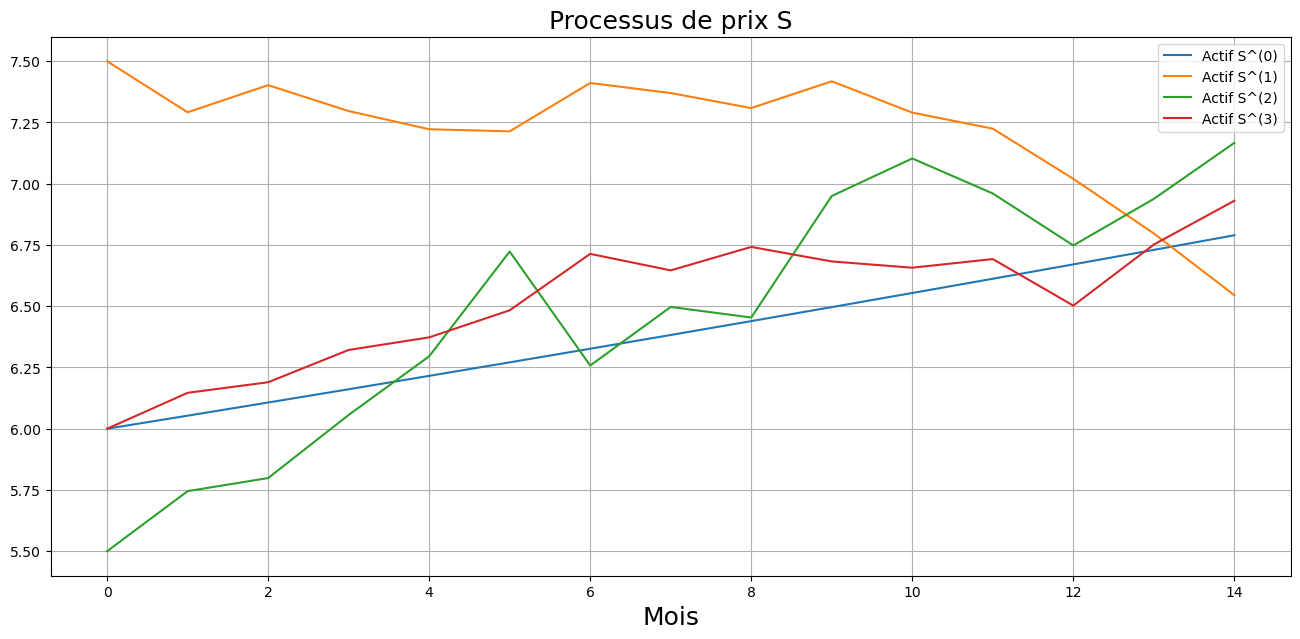

time: 151 ms (started: 2025-03-31 17:14:16 -04:00)


In [7]:
#Affichage du processus simulé :
plt.figure(figsize = (16,7))
plt.title('Processus de prix S', fontsize = 18)
plt.xlabel('Mois', fontsize = 18)
plt.grid(True)

mois = range(0, T)

for j in range(d+1):
    plt.plot(mois, S[ :, j], label='Actif S^({})'.format(j))
plt.legend()
plt.show()

##**Fonction d'utlité U et Affichage**

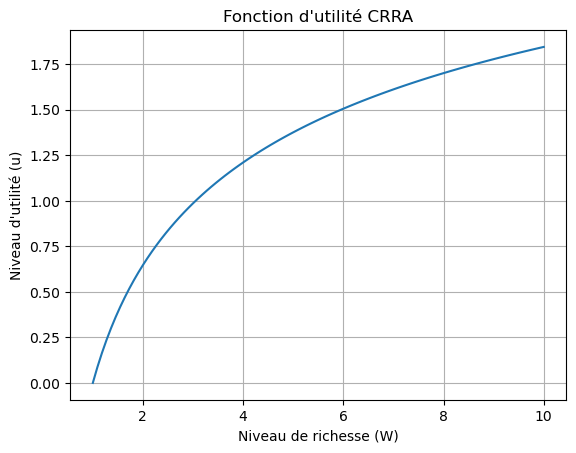

time: 62.4 ms (started: 2025-03-31 17:14:17 -04:00)


In [8]:

def U(W):
    """
    Fonction d'utilité CRRA (Constant Relative Risk Aversion)
    
    Paramètres :
        - W (float ou array) : Niveau de richesse
        - gamma (float) : Coefficient d'aversion au risque
        
    Retourne :
        - utility (float ou array) : Niveau d'utilité
    """
    if gamma != 1:
        utility = (W**(1 - gamma) -1) / (1 - gamma)
    else:
        utility = np.log(W)
    return utility


# Création d'un échantillon de niveaux de richesse
W = np.linspace(1, 10, 100)

# Calcul des niveaux d'utilité correspondants
u = U(W)

# Tracé de la fonction d'utilité
plt.plot(W, u)
plt.xlabel('Niveau de richesse (W)')
plt.ylabel('Niveau d\'utilité (u)')
plt.title('Fonction d\'utilité CRRA')
plt.grid(True)
plt.show()


In [9]:
# définitiion de la fonction de coût g
def g(S_t, alpha, t):
  if t == T:
    return U(np.max(S_t))
  elif np.sqrt(np.dot(alpha[1:], np.dot(Cov, alpha[1:]))) < R_0:
    R_t = np.sqrt(np.dot(alpha[1:], np.dot(Cov, alpha[1:])))
    W_t = np.dot(alpha, S_t)
    return float(U(W_t - gamma * R_t * W_t))
  else: 
    return 0

time: 434 µs (started: 2025-03-31 17:14:17 -04:00)


# **CHAÎNAGE ARRIÈRE**

##**Fonction de discrétisation des états**

In [10]:
#définition d'une fonction de discrétisation des états :
def discretize_etats(t, nbre_etats):
    """
    Renvoie un nombre d'états nombre_etats à chaque étape t

    Arguments:
        t (int): Étape t.
        nbre_etats (int): Nombre d'états voulus à l'instant t.
    Retourne:
        np.array: Matrice numpy avec les valeurs discrétisées de x_t et y_t.
    """ 
    M = np.zeros([nbre_etats, d+1])
    
    for j in range(d):
      M[:, 0] = S[t, 0]
      value = np.random.uniform(S[t, j+1] - 1.96 * sigma[j], S[t, j+1] + 1.96 * sigma[j], nbre_etats)
      M[:, j+1] = value

    return M

time: 461 µs (started: 2025-03-31 17:14:17 -04:00)


##**Fonction de calcul d'espérance**

In [11]:
def calcul_esperance_g(S, func_g, alpha, tmp, nb_echantillons=100):
    """
    Calcule l'espérance de la fonction g(S, alpha, t)
    Args:
        S (array-like): Vecteur de valeurs de S.
        func_g (callable): Fonction func_g(S, alpha, t) à évaluer. La fonction doit prendre en entrée un 
                      vecteur S, un vecteur d'allocation alpha
                      et un scalaire t, et renvoyer un scalaire en sortie.
        nb_echantillons (int, optional): Nombre d'échantillons à générer pour chaque variable aléatoire.
                                         Plus le nombre d'échantillons est grand, plus l'estimation de
                                         l'espérance sera précise. Par défaut, nb_echantillons=100.
    
    Returns:
        float-like: Espérance de la fonction g(S, alpha, t), sous forme de scalaire.
    """
    # Générer les échantillons pour chaque composante de Z
    nb_composantes = len(S[1:])
    new_vecteur = np.zeros([nb_echantillons, nb_composantes+1])
    new_vecteur[:, 0] = S[0]
    Z_echantillons = np.random.normal(0., 0.5, size=(nb_echantillons, nb_composantes))
    #Z_echantillons = np.random.multivariate_normal(mean=S[1:], cov=Cov, size=nb_echantillons)
    new_vecteur[:, 1:] = S[1:] + Z_echantillons

    
    # Calculer la fonction g pour chaque échantillon de Z et la sortie de f
    #g_echantillons = np.array([func_g(sortie_func_f, alpha, t_flot) for sortie_func_f in f_echantillons])
    g_echantillons = np.array([func_g(echantillon, alpha, tmp) for echantillon in new_vecteur])

    # Calculer la moyenne des résultats obtenus
    esperance = np.mean(g_echantillons)
    
    return esperance

time: 979 µs (started: 2025-03-31 17:14:17 -04:00)


##**Détermination des politques**

In [12]:
#On va discrétiser l'ensemble des états en utilisant la fonction discretize_etats à l'étape t

X = np.zeros([n_etats, d+1])

# Tableau pour stocker les valeurs de J
J = np.zeros([T, n_etats])  

#Discrétisation des alpha_t en dt
dt = 0.01

# Création de la matrice d'états pour stocker ceux de la méthode exacte
M_etats_t = np.empty((T, n_etats, d+1))

# Étape T : Utilité à l'étape finale            
X = discretize_etats(T-1, n_etats)
M_etats_t[T-1] = X

print(f"Étape finale T : {T}")
for j in range(n_etats):
  J[T-1, j] = g(X[j, :], [1, 1, 1, 1], T)
  print(f"J[etat {j+1}] = {J[T-1, j]}")
print(f" ")


# Étapes t = T-1 à 0 : Mise à jour de J en remontant
for t in range(T - 1, 0, -1):
  print(f"Étape : {t}")
  X = discretize_etats(t, n_etats)
  M_etats_t[t] = X
  for j in range(n_etats):
    a = X[j, :]
    J_t_max = float("-inf")  # Initialise le vecteur J_t_max correspondant à la valeur maximale de J_t pour chaque état
    cout_expere = 0
    print(f"Prix S[{t}] = {a}")
    for alpha_t0 in np.arange(0, 1+dt, dt):  # Discrétisation de [0, 1] avec dt valeurs pour alpha_t^0
        for alpha_t1 in np.arange(0, alpha_t0+dt, dt):  # Discrétisation de [0, 1] avec dt valeurs pour alpha_t^1
          if alpha_t0 + alpha_t1 <= 1:
            for alpha_t2 in np.arange(0, alpha_t1+dt, dt):  # Discrétisation de [0, 1] avec dt valeurs pour alpha_t^2
              if alpha_t0 + alpha_t1 + alpha_t2 <= 1:
                alpha_t3 = 1 - alpha_t0 - alpha_t1 - alpha_t2  # Contrainte de somme à 1 pour les allocations
                alpha_t = np.array([alpha_t0, alpha_t1, alpha_t2, alpha_t3])
                cout_expere = calcul_esperance_g(S = a, func_g=g, alpha=alpha_t, tmp=t, nb_echantillons=1)
                J_t = cout_expere + J[t, j] 
                if J_t_max < J_t:
                  J_t_max = J_t
                  alpha_t_max = alpha_t
    J[t-1, j] = J_t_max
    print(f"J[etat {j+1}, allocation optimale = {alpha_t_max}] = {J[t-1, j]}")
    print(f"")
  print(f"\n")

Étape finale T : 15
J[etat 1] = 1.628589187164816
J[etat 2] = 1.6203786152261794
J[etat 3] = 1.6202724500752534
J[etat 4] = 1.6286965764606418
J[etat 5] = 1.6310961518516018
J[etat 6] = 1.6294366805665592
J[etat 7] = 1.6287613900083984
J[etat 8] = 1.6342905176867648
J[etat 9] = 1.6235556289551083
J[etat 10] = 1.6323167686156257
 
Étape : 14
Prix S[14] = [6.78963111 6.52411418 7.15676484 6.86578544]
J[etat 1, allocation optimale = [0.09 0.08 0.   0.83]] = 3.340194215367581

Prix S[14] = [6.78963111 6.59412028 7.14743745 6.9840344 ]
J[etat 2, allocation optimale = [0.17 0.12 0.   0.71]] = 3.307985166830826

Prix S[14] = [6.78963111 6.49920942 7.13741798 6.91575321]
J[etat 3, allocation optimale = [0.03 0.01 0.01 0.95]] = 3.352004608851491

Prix S[14] = [6.78963111 6.54656671 7.17559106 6.92968672]
J[etat 4, allocation optimale = [0.1  0.02 0.02 0.86]] = 3.33826579490135

Prix S[14] = [6.78963111 6.52645409 7.24720448 6.93602026]
J[etat 5, allocation optimale = [0.23 0.13 0.02 0.62]] = 3.

##**Affichage des coûts en fonction des politiques**

###**En 2D**

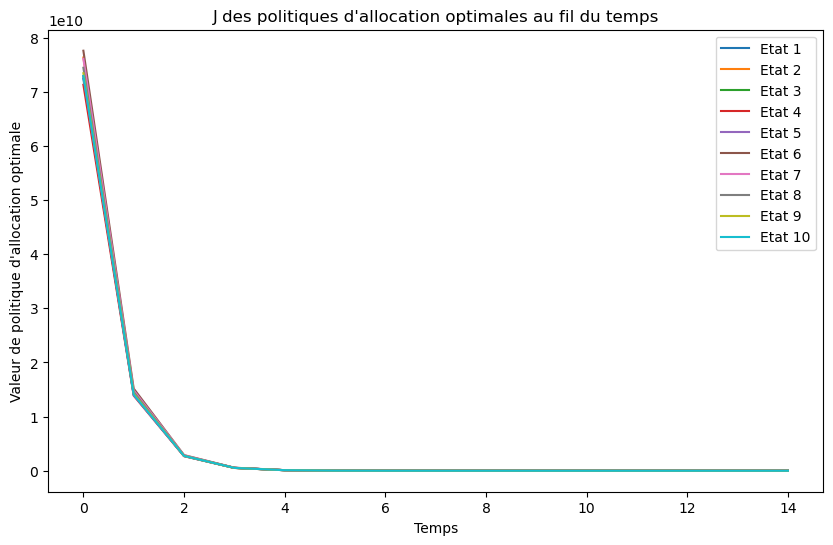

time: 99.8 ms (started: 2025-03-31 17:15:45 -04:00)


In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les états pour tracer les politiques d'allocation optimales
for j in range(n_etats):
    # Tracer la politique d'allocation optimale pour l'état j
    ax.plot(range(T), np.exp(J[:, j]), label='Etat {}'.format(j+1))

# Ajouter une légende
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Valeur de politique d\'allocation optimale')
ax.set_title('J des politiques d\'allocation optimales au fil du temps')
plt.show()


###**En 3D**

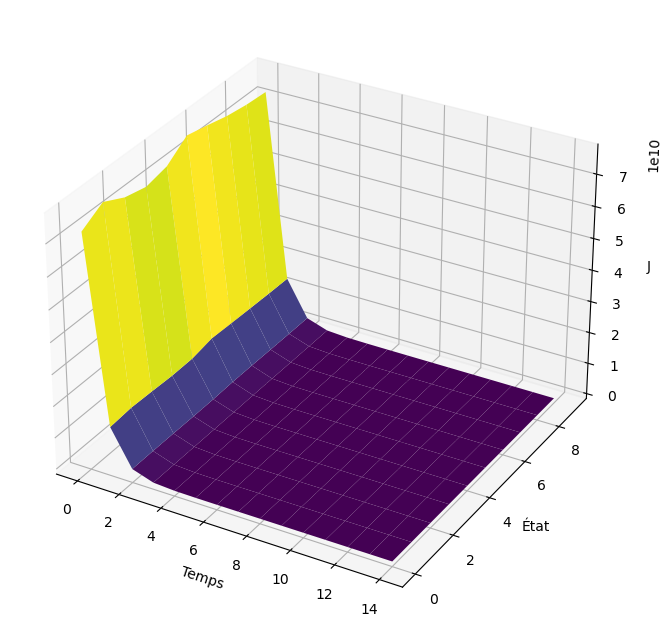

time: 115 ms (started: 2025-03-31 17:15:45 -04:00)


In [14]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer les axes pour le temps et les états
temps = np.arange(0, T)
etats = np.arange(0, n_etats)
temps, etats = np.meshgrid(temps, etats)

# Tracer la surface en 3D
surf = ax.plot_surface(temps, etats, np.exp(J).T, cmap='viridis')

# Ajouter une étiquette pour l'axe x
ax.set_xlabel('Temps')

# Ajouter une étiquette pour l'axe y
ax.set_ylabel('État')

# Ajouter une étiquette pour l'axe z
ax.set_zlabel('J')

# Afficher la figure
plt.show()


# **MÉTHODE APPROXIMATIVE ET ANALYSE DE RÉSULTATS**

##**Génération de l'architecture de données**

In [15]:
# Génération des données d’apprentissage pour l'apprentissage supervisé
data_etats = []
data_couts = []
data_allocations = []


# Tableau pour stocker les valeurs de J_tilde
J_tilde = np.zeros([T, n_etats])
J_tilde[-1, :]= J[-1, :]

#X = discretize_etats(T-1, n_etats)

#print(f"Étape finale T : {T}")
#for j in range(n_etats):
  #print(f"J_tilde[etat {j+1}] = {J_tilde[T-1, j]}")
  #data_etats.append(X[j, :])
  #data_couts.append(J_tilde[T-1, j])
#print(f" ")

#nombre d'essai pour trouver les allocations optimales
nbre_essai = 100

# Boucle pour générer les données pour l'apprentissage
for t in range(T-1, 0, -1):
  #print(f"Étape : {t}")
  X = discretize_etats(t, n_etats) # Discrétisation des états à l'instant t
  for j in range(n_etats):
    J_tilde_t_max = float("-inf")  # Initialise le vecteur J_t_tilde_max correspondant à la valeur maximale de J_t
    # Génération d'une allocation aléatoire sous forme de vecteur de probabilités
    #print(f"Prix S[{t}] : {X[j, :]}")
    for essai in range(nbre_essai):
      a = np.random.dirichlet(np.ones(d+1))
      if np.sqrt(np.dot(a[1:], np.dot(Cov, a[1:]))) < R_0:
        c = calcul_esperance_g(S = X[j, :], func_g=g, alpha=a, tmp=t, nb_echantillons=100)
        cout_cumul_t = c + J_tilde[t, j]
        if J_tilde_t_max < cout_cumul_t:
          J_tilde_t_max = cout_cumul_t
          a_max = a
    J_tilde[t - 1, j] = J_tilde_t_max
    #print(f"J_tilde[etat {j+1}, allocation optimale = {a_max}] = {J_tilde[t-1, j]}")
    #print(f"")
    data_allocations.append(a)
    data_etats.append(X[j, :])
    data_couts.append(J_tilde[t - 1, j])
  #print(f"")

time: 9.55 s (started: 2025-03-31 17:15:45 -04:00)


In [16]:
# Préparation des données d'apprentissage sous forme de tableaux NumPy. J'ai pas vu après l'utilité de alloc_train
#X_train représente les valeurs des états et y_train représente les J_tildes
X_train = np.array(data_etats)
y_train = np.array(data_couts)
alloc_train = np.array(data_allocations)
#alloc_train
#X_train
#y_train

time: 1.43 ms (started: 2025-03-31 17:15:55 -04:00)


##**Fitted Value Iteration**


###**Régression linéaire**

In [17]:
#Régression linéaire

# Créer un objet de régression linéaire
model_reg = LinearRegression()

# Entraîner le modèle de régression linéaire avec les données d'entraînement
model_reg.fit(X_train, y_train)

LinearRegression()

time: 13.5 ms (started: 2025-03-31 17:15:55 -04:00)


###**Détermination des J_tilde de la régression linéaire ajustés en J_hat**

In [18]:
# Mise à jour des politiques d'allocation
# Utilisation du modèle entraîné pour obtenir les politiques d'allocation optimales :
etat_reg_politique = []
politique_reg_allocation = []
J_hat_reg_politique = [] 

#On va utiliser les états de la méthode exacte.

# Tableau pour stocker les valeurs de J_hat et le score de la régression faite en même temps
score = np.zeros(T)
J_hat_reg = np.zeros([T, n_etats])
X = M_etats_t[T-1]
J_hat_reg[-1, :]= model_reg.predict(X)
score[T-1] = model_reg.score(X, J_hat_reg[-1, :])

for t in range(T-1, 0, -1):
  X = M_etats_t[t]
  for j in range(n_etats):
    J_hat_reg_max = float("-inf")  # Initialise le vecteur J_hat_reg_max correspondant à la valeur maximale de J_hat_reg
    J_reg_predict = model_reg.predict(X)
    score[t] = model_reg.score(X, J_reg_predict)
    for essai in range(nbre_essai):
      a = np.random.dirichlet(np.ones(d+1))
      if np.sqrt(np.dot(a[1:], np.dot(Cov, a[1:]))) < R_0:
        c = calcul_esperance_g(S=X[j, :], func_g=g, alpha = a, tmp = t)
        c_cumul = c + J_reg_predict[j]
        if J_hat_reg_max < c_cumul:
          J_hat_reg_max = c_cumul
          alpha_reg_max = a
    J_hat_reg[t-1, j] = J_hat_reg_max
    politique_reg_allocation.append(alpha_reg_max)
    etat_reg_politique.append(X[j, :])
    J_hat_reg_politique.append(J_hat_reg[t, j])

#À la fin, on a donc nos coûts J_hat_reg estimés

time: 9.57 s (started: 2025-03-31 17:15:55 -04:00)


In [19]:
alloc_reg = np.array(politique_reg_allocation)
etat_reg = np.array(etat_reg_politique)

time: 1.24 ms (started: 2025-03-31 17:16:04 -04:00)


In [20]:
alloc_reg

array([[1.61651295e-01, 8.43394109e-02, 6.29443667e-01, 1.24565627e-01],
       [5.64237433e-02, 1.04893827e-02, 5.41377889e-01, 3.91708985e-01],
       [1.22542562e-01, 3.07408190e-02, 4.63929954e-01, 3.82786666e-01],
       [3.69985381e-01, 7.37101748e-03, 3.79900489e-01, 2.42743112e-01],
       [2.26129992e-02, 1.31169717e-01, 7.83771811e-01, 6.24454727e-02],
       [2.05305348e-01, 2.47130223e-03, 4.72523052e-01, 3.19700297e-01],
       [1.29271163e-02, 1.11173484e-02, 6.22557353e-01, 3.53398182e-01],
       [5.88698676e-02, 2.07201139e-03, 6.00696140e-01, 3.38361981e-01],
       [2.81762652e-01, 8.37598803e-02, 4.56471706e-01, 1.78005762e-01],
       [2.43292561e-01, 4.81138333e-02, 2.33281171e-01, 4.75312435e-01],
       [2.66362101e-01, 4.15236707e-01, 2.49458894e-01, 6.89422988e-02],
       [2.54335251e-01, 3.12754464e-01, 2.47117272e-01, 1.85793014e-01],
       [4.86719059e-03, 5.01466884e-01, 4.65336639e-01, 2.83292864e-02],
       [5.25855001e-02, 6.39901724e-01, 2.69520805e

time: 8.33 ms (started: 2025-03-31 17:16:04 -04:00)


###**Affichage de résultats**

/Users/juvenalagbanou/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py:906: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/Users/juvenalagbanou/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/art3d.py:908: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


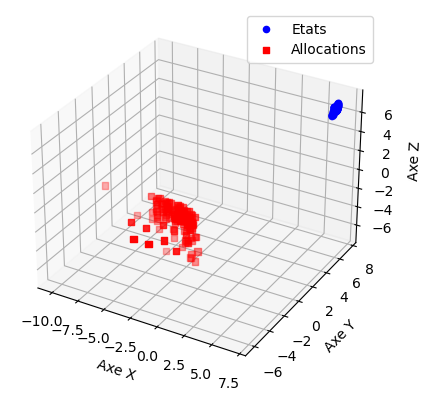

time: 124 ms (started: 2025-03-31 17:16:04 -04:00)


In [21]:
# Figure 3D optionnelle
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracé des états et des allocations en tant que points dans l'espace 3D
ax.scatter(etat_reg[:, 0], etat_reg[:, 1], etat_reg[:, 2], etat_reg[:, 3], c='b', marker='o', label='Etats')
ax.scatter(np.log(alloc_reg[:, 0]), np.log(alloc_reg[:, 1]), np.log(alloc_reg[:, 2]), np.log(alloc_reg[:, 3]), c='r', marker='s', label='Allocations')

#ax.plot_surface(etat_reg[:, 0], etat_reg[:, 1], etat_reg[:, 2], etat_reg[:, 3], cmap='Blues', alpha=0.5, edgecolor='none', label='Etats')
#ax.plot_surface(np.log(alloc_reg[:, 0]), np.log(alloc_reg[:, 1]), np.log(alloc_reg[:, 2]), np.log(alloc_reg[:, 3], cmap='Reds', alpha=0.5, edgecolor='none', label='Allocations')


# Définir les étiquettes des axes
ax.set_xlabel('Axe X')
ax.set_ylabel('Axe Y')
ax.set_zlabel('Axe Z')

# Définir les limites des axes pour mieux visualiser les données
#ax.set_xlim(-7.5, 0)
#ax.set_ylim(0, 8)
#ax.set_zlim(0, 10)
# Afficher une légende
ax.legend()

# Afficher la figure
plt.show()


In [22]:
J_hat_reg

array([[25.64035055, 25.60726051, 25.62123539, 25.62174931, 25.6203989 ,
        25.62760279, 25.62987029, 25.62680602, 25.63946563, 25.61278129],
       [24.04965645, 24.05269928, 24.06887739, 24.05278779, 24.0723079 ,
        24.05433331, 24.04396752, 24.04009953, 24.04585223, 24.06197062],
       [22.518679  , 22.48941984, 22.52005812, 22.50421335, 22.5349979 ,
        22.52727804, 22.50503382, 22.47663296, 22.49765246, 22.50329618],
       [20.94381239, 20.97798234, 20.96305767, 20.95316055, 20.98808961,
        20.95543534, 20.95276632, 20.9482162 , 20.94782129, 20.97308045],
       [19.35676763, 19.31663053, 19.35618855, 19.35773358, 19.31386831,
        19.30552135, 19.33505019, 19.36136064, 19.34254227, 19.33204253],
       [17.67566386, 17.68676382, 17.69334484, 17.67628508, 17.69236152,
        17.70187025, 17.7144821 , 17.71482147, 17.69542123, 17.69660719],
       [16.08989809, 16.11762487, 16.11547156, 16.09149447, 16.0807679 ,
        16.10151525, 16.09099938, 16.11511411

time: 3.77 ms (started: 2025-03-31 17:16:05 -04:00)


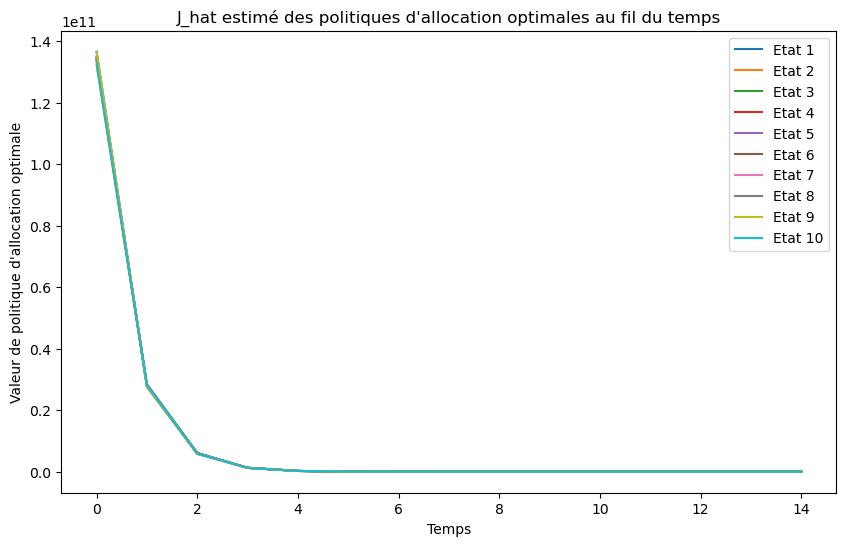

time: 120 ms (started: 2025-03-31 17:16:05 -04:00)


In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les états pour tracer les politiques d'allocation optimales
for j in range(n_etats):
    # Tracer la politique d'allocation optimale pour l'état j
    ax.plot(range(T), np.exp(J_hat_reg[:, j]), label='Etat {}'.format(j+1))

# Ajouter une légende
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Valeur de politique d\'allocation optimale')
ax.set_title('J_hat estimé des politiques d\'allocation optimales au fil du temps')
plt.show()


In [24]:
# Évaluer les performances du modèle
score

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

time: 2.2 ms (started: 2025-03-31 17:16:05 -04:00)


In [25]:
# Afficher les coefficients de régression (poids)
coefficients = model_reg.coef_
coefficients

array([-28.40017171,  -0.41507434,  -0.09235061,  -0.16034622])

time: 3.24 ms (started: 2025-03-31 17:16:05 -04:00)


In [26]:
# Afficher l'ordonnée à l'origine (intercept)
ordonnee_origine = model_reg.intercept_
ordonnee_origine

200.4854591733622

time: 26.1 ms (started: 2025-03-31 17:16:05 -04:00)


###**Affichage de la performance par rapport à la méthode exacte**

####**Erreur absolue**


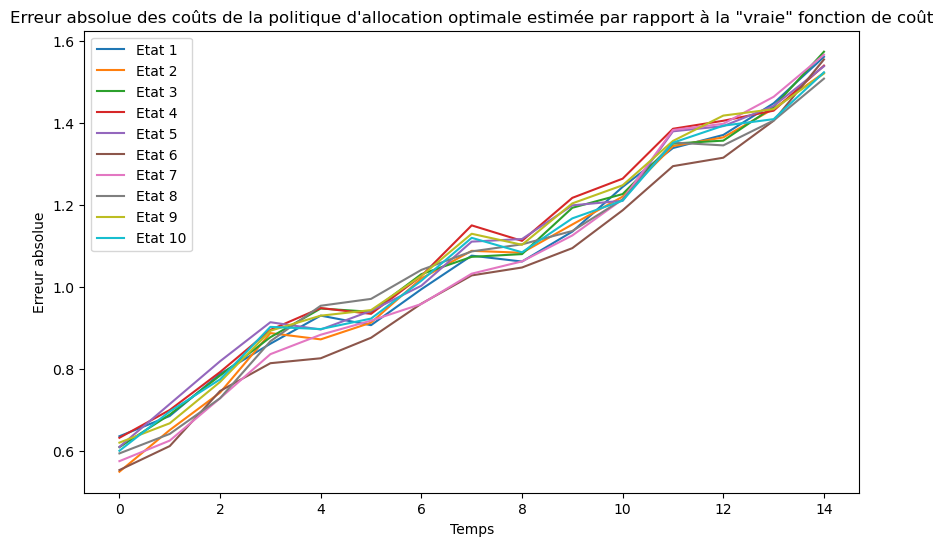

time: 102 ms (started: 2025-03-31 17:16:05 -04:00)


In [27]:
# Calculer l'erreur absolue
erreur_absolue = np.abs(J_hat_reg - J)

# Créer un graphique en ligne pour afficher l'erreur absolue au fil du temps
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les états pour tracer l'erreur absolue
for j in range(n_etats):
    # Tracer l'erreur absolue pour l'état j
    ax.plot(range(T), erreur_absolue[:, j], label='Etat {}'.format(j+1))

# Ajouter une légende
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Erreur absolue')
ax.set_title('Erreur absolue des coûts de la politique d\'allocation optimale estimée par rapport à la "vraie" fonction de coût')

plt.show()


####**Erreur relative**

#####**En 2D**

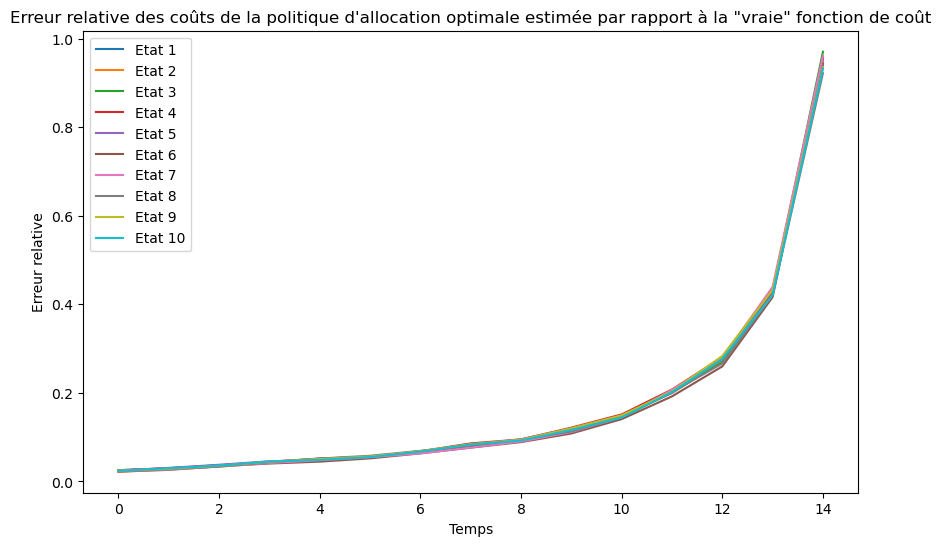

time: 122 ms (started: 2025-03-31 17:16:05 -04:00)


In [28]:
# Calculer l'erreur relative
erreur_relative = (J_hat_reg - J) / J

# Créer un graphique en ligne pour afficher l'erreur relative au fil du temps
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les états pour tracer l'erreur relative
for j in range(n_etats):
    # Tracer l'erreur relative pour l'état j
    ax.plot(range(T), erreur_relative[:, j], label='Etat {}'.format(j+1))

# Ajouter une légende
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Erreur relative')
ax.set_title('Erreur relative des coûts de la politique d\'allocation optimale estimée par rapport à la "vraie" fonction de coût')

plt.show()


#####**En 3D**

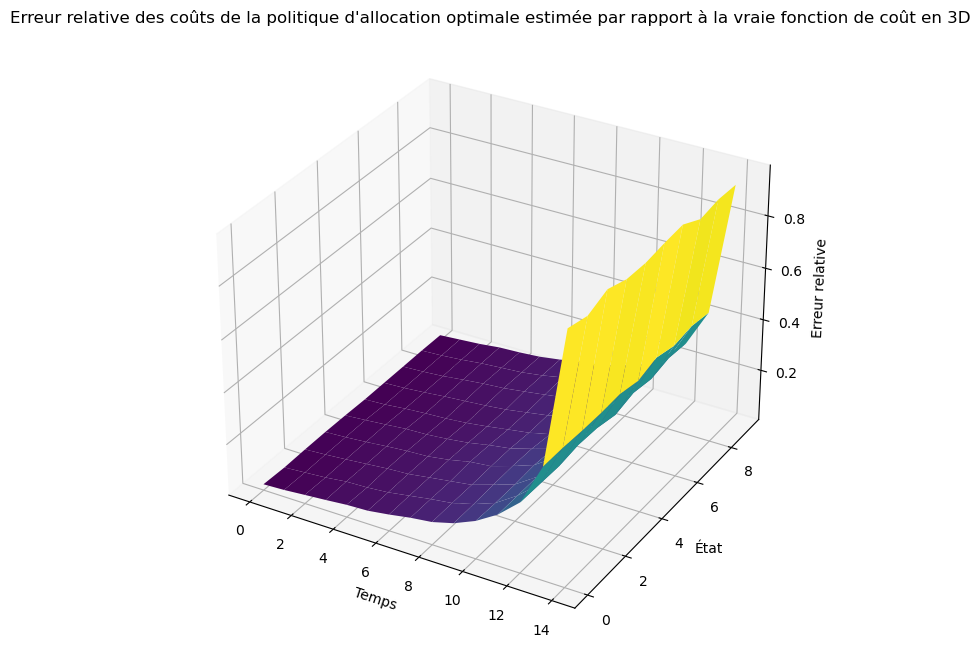

time: 84.4 ms (started: 2025-03-31 17:16:05 -04:00)


In [29]:
# Supposons que vous avez la matrice de politique d'allocation optimale J_hat de taille T * n_etats
# et la vraie fonction de coût J de même taille

# Calculer l'erreur relative
erreur_relative = (J_hat_reg - J) / J

# Créer une figure en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer les axes pour le temps et les états
temps = np.arange(0, T)
etats = np.arange(0, n_etats)
temps, etats = np.meshgrid(temps, etats)
erreur_relative = np.array(erreur_relative)

# Tracer la surface en 3D
surf = ax.plot_surface(temps, etats, erreur_relative.T, cmap='viridis')

# Ajouter une étiquette pour l'axe x
ax.set_xlabel('Temps')

# Ajouter une étiquette pour l'axe y
ax.set_ylabel('État')

# Ajouter une étiquette pour l'axe z
ax.set_zlabel('Erreur relative')

# Ajouter un titre
ax.set_title('Erreur relative des coûts de la politique d\'allocation optimale estimée par rapport à la vraie fonction de coût en 3D')

# Afficher la figure
plt.show()


##**Réseau de neurones**

###**Régression neuronale**

In [30]:
#Régression par réseau de neurones
model_neural = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=20000)
model_neural.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(50,), max_iter=20000)

time: 1.3 s (started: 2025-03-31 17:16:05 -04:00)


###**Détermination des J_tilde de la régression neuronale ajustés en J_hat**

In [31]:
# Mise à jour des politiques d'allocation
# Utilisation du modèle entraîné pour obtenir les politiques d'allocation optimales :
etat_neural_politique = []
politique_neural_allocation = []
J_hat_neural_politique = [] 

# Tableau pour stocker les valeurs de J_hat
J_hat_neural = np.zeros([T, n_etats])
X = M_etats_t[T-1]
J_hat_neural[-1, :]= model_neural.predict(X)

for t in range(T-1, 0, -1):
  X = M_etats_t[t]
  for j in range(n_etats):
    J_hat_neural_max = float("-inf")  # Initialise le vecteur J_t_tilde_max correspondant à la valeur maximale de J_t
    J_neural_predict = model_neural.predict(X)
    for essai in range(nbre_essai):
      a = np.random.dirichlet(np.ones(d+1))
      if np.sqrt(np.dot(a[1:], np.dot(Cov, a[1:]))) < R_0:
        c = calcul_esperance_g(S=X[j, :], func_g=g, alpha = a, tmp = t)
        c_cumul = c + J_neural_predict[j]
        if J_hat_neural_max < c_cumul:
          J_hat_neural_max = c_cumul
          alpha_neural_max = a
    J_hat_neural[t-1, j] = J_hat_neural_max
    politique_neural_allocation.append(alpha_neural_max)
    etat_neural_politique.append(X[j, :])
    J_hat_neural_politique.append(J_hat_neural[t, j])


time: 9.52 s (started: 2025-03-31 17:16:06 -04:00)


In [32]:
J_hat_neural

array([[25.12120327, 25.22999424, 25.26486468, 24.84224465, 24.40075924,
        24.31765743, 24.11535653, 24.9140681 , 24.73132032, 24.40927367],
       [25.76668861, 25.22840161, 25.31527679, 25.23534119, 24.85487632,
        24.40501946, 24.78805603, 25.32576426, 24.40365047, 24.87083693],
       [21.87071132, 22.76607076, 22.39897121, 22.40424904, 22.03292931,
        22.57702905, 23.00808313, 23.0170225 , 22.44128817, 22.66913562],
       [19.97623616, 19.92948734, 18.78299369, 20.05329237, 19.40349329,
        19.62433866, 20.27109498, 19.17779617, 21.06000202, 19.47147787],
       [17.69791365, 17.72442994, 17.04087903, 17.1885912 , 17.84106441,
        18.11343281, 17.12640806, 17.05086491, 17.02508499, 17.37629075],
       [19.06220575, 18.9597889 , 19.09859512, 18.94534371, 18.04590543,
        18.81346842, 18.19158481, 18.39542951, 17.98094206, 17.41122652],
       [16.98974093, 16.17525139, 16.63284967, 17.83342598, 17.43846545,
        16.58693179, 17.49145514, 16.12597029

time: 3.22 ms (started: 2025-03-31 17:16:16 -04:00)


###**Affichage de résultats**

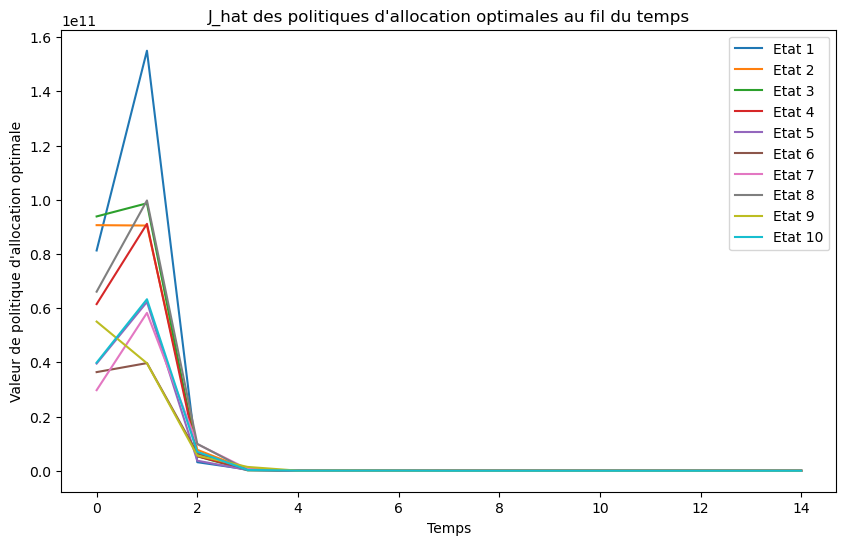

time: 99.1 ms (started: 2025-03-31 17:16:16 -04:00)


In [33]:
# sourcery skip: use-fstring-for-formatting
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les états pour tracer les politiques d'allocation optimales
for j in range(n_etats):
    # Tracer la politique d'allocation optimale pour l'état j
    ax.plot(range(T), np.exp(J_hat_neural[:, j]), label='Etat {}'.format(j+1))

# Ajouter une légende
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Valeur de politique d\'allocation optimale')
ax.set_title('J_hat des politiques d\'allocation optimales au fil du temps')
plt.show()

###**Affichage de la performance par rapport à la méthode exacte**

####**Erreur absolue**


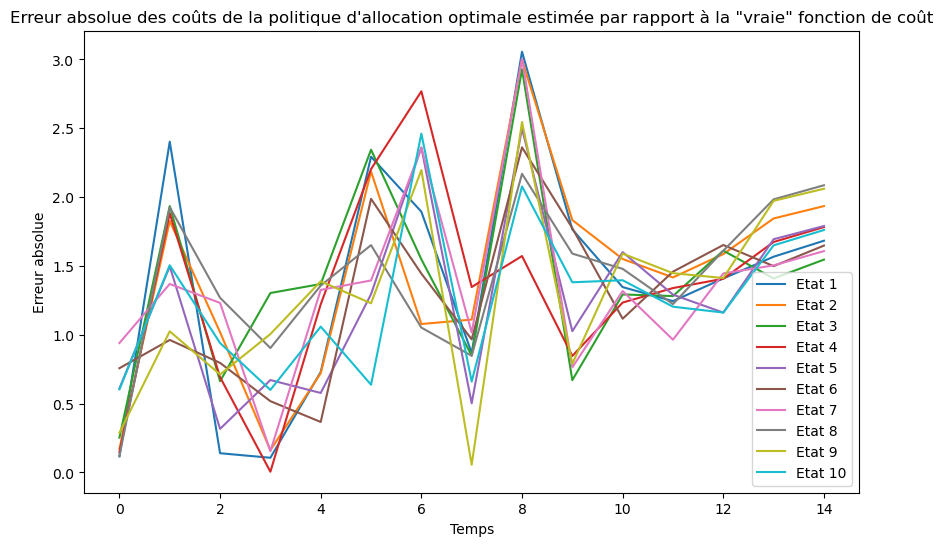

time: 116 ms (started: 2025-03-31 17:16:16 -04:00)


In [34]:
# Calculer l'erreur absolue
erreur_absolue = np.abs(J_hat_neural - J)

# Créer un graphique en ligne pour afficher l'erreur absolue au fil du temps
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les états pour tracer l'erreur absolue
for j in range(n_etats):
    # Tracer l'erreur absolue pour l'état j
    ax.plot(range(T), erreur_absolue[:, j], label=f'Etat {j+1}')

# Ajouter une légende
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Erreur absolue')
ax.set_title('Erreur absolue des coûts de la politique d\'allocation optimale estimée par rapport à la "vraie" fonction de coût')

plt.show()


####**Erreur relative**

#####**En 2D**

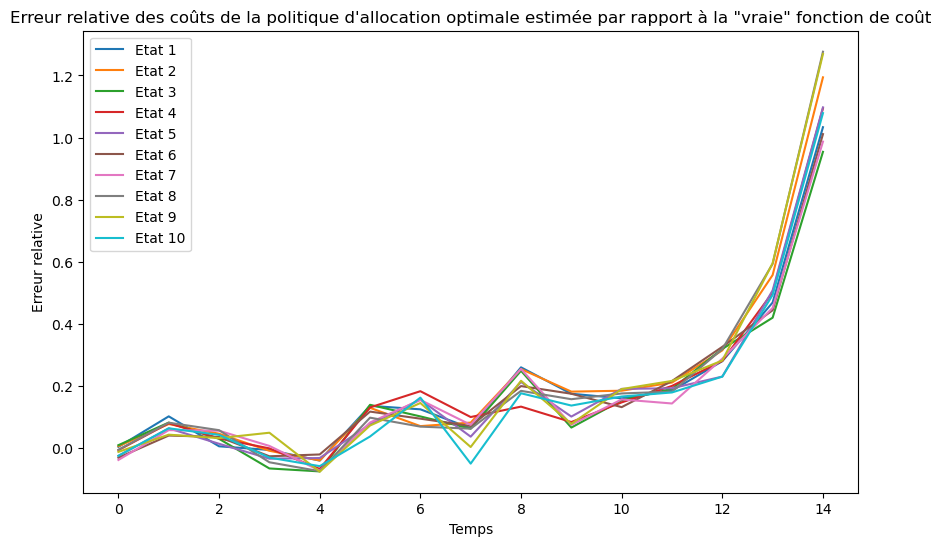

time: 181 ms (started: 2025-03-31 17:16:16 -04:00)


In [35]:
# Calculer l'erreur relative
erreur_relative = (J_hat_neural - J) / J

# Créer un graphique en ligne pour afficher l'erreur relative au fil du temps
fig, ax = plt.subplots(figsize=(10, 6))

# Parcourir les états pour tracer l'erreur relative
for j in range(n_etats):
    # Tracer l'erreur relative pour l'état j
    ax.plot(range(T), erreur_relative[:, j], label='Etat {}'.format(j+1))

# Ajouter une légende
ax.legend()
ax.set_xlabel('Temps')
ax.set_ylabel('Erreur relative')
ax.set_title('Erreur relative des coûts de la politique d\'allocation optimale estimée par rapport à la "vraie" fonction de coût')

plt.show()


In [36]:
J

array([[25.00484124, 25.058179  , 25.0122577 , 24.98995662, 25.01083813,
        25.07447154, 25.05502021, 25.03306837, 25.01947973, 25.01259653],
       [23.36473234, 23.40204575, 23.38054257, 23.35332807, 23.35826017,
        23.44275239, 23.41904805, 23.39883161, 23.37873688, 23.36606788],
       [21.731245  , 21.74749571, 21.73657421, 21.71220493, 21.71665239,
        21.7814403 , 21.77683836, 21.74843854, 21.72976953, 21.72909326],
       [20.08272825, 20.09101841, 20.0861211 , 20.05839714, 20.07460455,
        20.14184686, 20.11716266, 20.0811144 , 20.05507951, 20.0709857 ],
       [18.4271819 , 18.44495665, 18.40936054, 18.40971066, 18.41819061,
        18.47992374, 18.45208685, 18.4077504 , 18.41314288, 18.43524453],
       [16.76935019, 16.77432777, 16.75448343, 16.7423673 , 16.75118378,
        16.82625836, 16.79719589, 16.74448223, 16.75239232, 16.77428487],
       [15.09597781, 15.09736566, 15.0848744 , 15.06520968, 15.07831999,
        15.14280685, 15.13309605, 15.07408094

time: 3.69 ms (started: 2025-03-31 17:16:16 -04:00)


#####**En 3D**

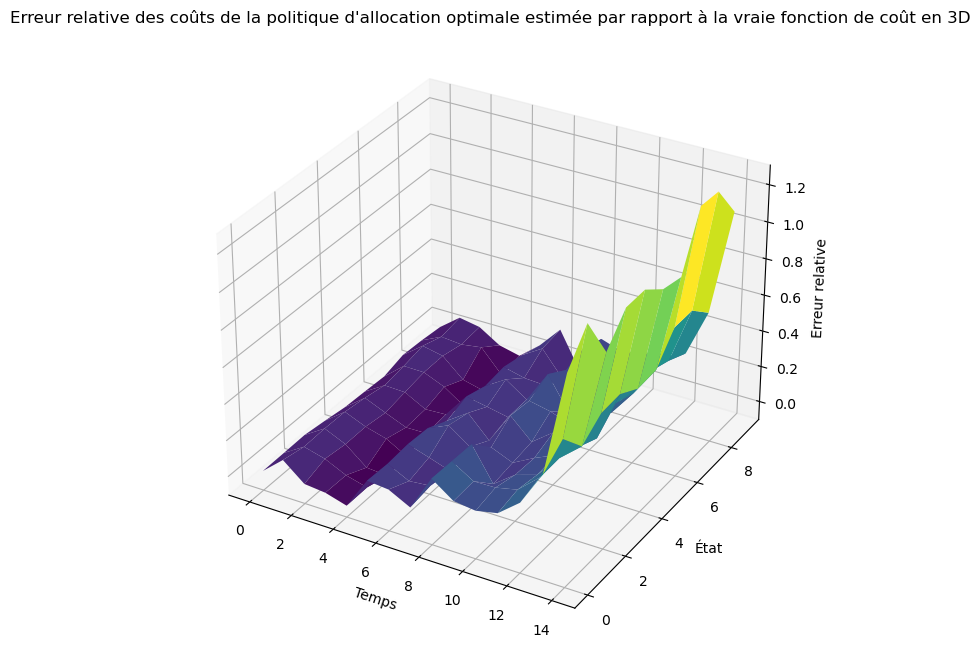

time: 127 ms (started: 2025-03-31 17:19:50 -04:00)


In [37]:
# Supposons que vous avez la matrice de politique d'allocation optimale J_hat de taille T * n_etats
# et la vraie fonction de coût J de même taille

# Calculer l'erreur relative
erreur_relative = (J_hat_neural - J) / J

# Créer une figure en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer les axes pour le temps et les états
temps = np.arange(0, T)
etats = np.arange(0, n_etats)
temps, etats = np.meshgrid(temps, etats)
erreur_relative = np.array(erreur_relative)

# Tracer la surface en 3D
surf = ax.plot_surface(temps, etats, erreur_relative.T, cmap='viridis')

# Ajouter une étiquette pour l'axe x
ax.set_xlabel('Temps')

# Ajouter une étiquette pour l'axe y
ax.set_ylabel('État')

# Ajouter une étiquette pour l'axe z
ax.set_zlabel('Erreur relative')

# Ajouter un titre
ax.set_title('Erreur relative des coûts de la politique d\'allocation optimale estimée par rapport à la vraie fonction de coût en 3D')

# Afficher la figure
plt.show()
